Imports

In [1]:
# Cell 1: Imports
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from tools import BouncingBallSim, TransitionNet, generate_balanced_training_data, animate_trajectories

In [4]:
debug_sim = BouncingBallSim()
# Force a start near a wall to guarantee we see a bounce immediately
""" debug_sim.pos = np.array([30.0, 15.0]) 
debug_sim.vel = np.array([0., 0.]) """

print("Generating diagnostic sequence...")
# We grab 100 frames to verify the physics
vis_data = [debug_sim.step() for _ in range(80)] 
vis_truth = np.array([d[2] for d in vis_data]) # Extract Ground Truth (x, y)

# 2. Animate
# We pass 'vis_truth' as both ground_truth and estimates just to hack the 
# visualizer into showing a single colored line
anim = animate_trajectories(
    ground_truth=vis_truth, 
    estimates=None, 
    labels=["Training Physics"]
)

print("Check this video: Does the ball BOUNCE or stick to the wall?")
display(anim)

Generating diagnostic sequence...
Check this video: Does the ball BOUNCE or stick to the wall?


Train the Deep Model

Generating Balanced Training Data...
Training Deep Kalman Transition...


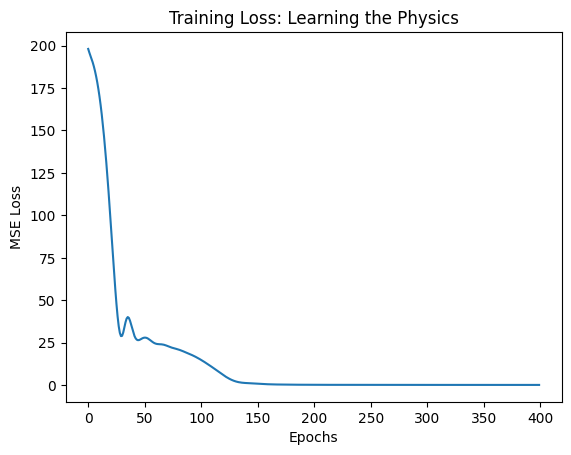

Final Loss: 0.107601


In [5]:
# --- STEP 1: TRAIN THE DEEP MODEL ---
print("Generating Balanced Training Data...")
train_x, train_y = generate_balanced_training_data(n_samples=5000)

model = TransitionNet()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

print("Training Deep Kalman Transition...")
losses = []
for epoch in range(400):
    optimizer.zero_grad()
    predictions = model(train_x)
    loss = criterion(predictions, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss: Learning the Physics")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()
print(f"Final Loss: {losses[-1]:.6f}")

Apply classical Kalman Filter

In [6]:
# --- STEP 2: SETUP CLASSICAL KALMAN FILTER ---
# High observation noise (5.0) + Low process noise (0.0001) = "Stubborn Filter"
# This forces the filter to rely on its Linear model, causing it to overshoot at bounces.
kf = KalmanFilter(
    transition_matrices=[[1,0,1,0], [0,1,0,1], [0,0,1,0], [0,0,0,1]],
    observation_matrices=[[1,0,0,0], [0,1,0,0]],
    transition_covariance=np.eye(4)*0.0001, 
    observation_covariance=np.eye(2)*5.0,
)

# --- STEP 3: RUN THE EXPERIMENT ---
# Generate a new test sequence
sim = BouncingBallSim()
test_data = [sim.step() for _ in range(80)]
observations = np.array([d[0] for d in test_data]) # Noisy measurements
ground_truth = np.array([d[2] for d in test_data]) # Actual positions

# Initial State: [x_pos, y_pos, x_vel, y_vel]
# We use the first observation for position, and guess 0 for velocity
kf.initial_state_mean = [observations[0, 0], observations[0, 1], 0, 0]

# Now run the filter
kf_mean, _ = kf.filter(observations)

Run the Deep Kalman Filter

In [7]:
# B. Run Deep KF (Iterative Filtering)
dkf_est = []
# Initialize with first observation + default velocity guess
current_state = torch.FloatTensor(np.concatenate([observations[0], [1.5, 0.75]]))
dkf_est.append(current_state.numpy())

with torch.no_grad():
    # Loop starting from index 1 (predicting t=1 using t=0)
    for z in observations[1:]:
        # 1. PREDICT next state using Neural Network
        prediction = model(current_state.unsqueeze(0)).squeeze(0)
        
        # 2. UPDATE (Correction)
        # Simple weighted average (Kalman Gain approx 0.2)
        z_tensor = torch.FloatTensor(z)
        pred_pos = prediction[:2]
        residual = z_tensor - pred_pos
        corrected_pos = pred_pos + 0.2 * residual
        
        # Update State
        current_state = prediction.clone()
        current_state[:2] = corrected_pos
        dkf_est.append(current_state.numpy())

dkf_est = np.array(dkf_est)

Visualize both results

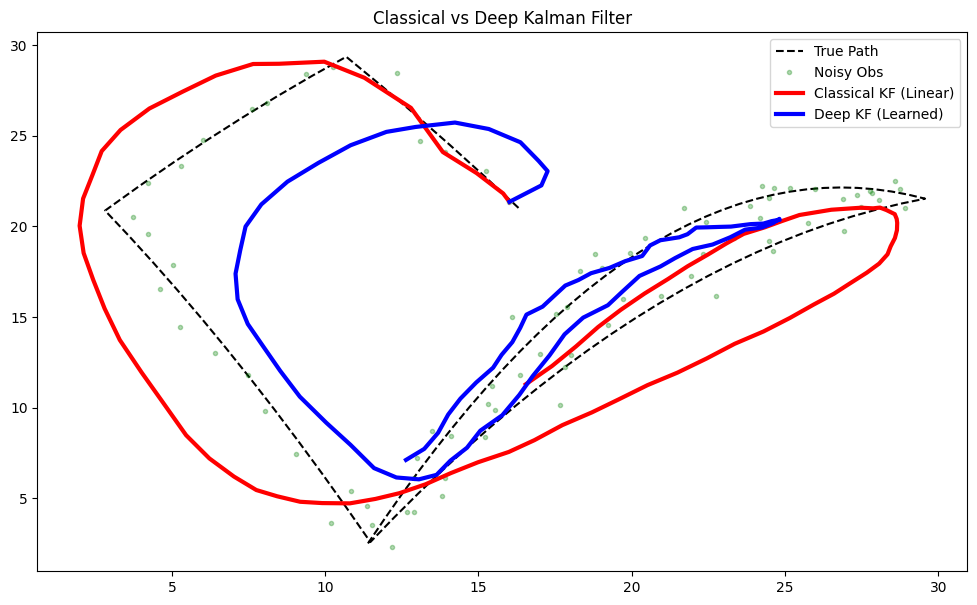

In [8]:

# --- STEP 4: VISUALIZE RESULTS ---
# Static Plot
plt.figure(figsize=(12, 7))
plt.plot(ground_truth[:,0], ground_truth[:,1], 'k--', label='True Path')
plt.plot(observations[:,0], observations[:,1], 'g.', alpha=0.3, label='Noisy Obs')
plt.plot(kf_mean[:,0], kf_mean[:,1], 'r-', linewidth=3, label='Classical KF (Linear)')
plt.plot(dkf_est[:,0], dkf_est[:,1], 'b-', linewidth=3, label='Deep KF (Learned)')

# Annotate the Bounce
bounce_idx = np.where(np.diff(np.sign(ground_truth[:, 2:]), axis=0) != 0)[0]
if len(bounce_idx) > 0:
    idx = bounce_idx[0]
    plt.annotate('Linear Overshoot', xy=(kf_mean[idx,0], kf_mean[idx,1]), 
                 xytext=(kf_mean[idx,0]+5, kf_mean[idx,1]+5),
                 arrowprops=dict(facecolor='red', shrink=0.05))
    plt.annotate('Deep Turn', xy=(dkf_est[idx,0], dkf_est[idx,1]), 
                 xytext=(dkf_est[idx,0]-10, dkf_est[idx,1]-5),
                 arrowprops=dict(facecolor='blue', shrink=0.05))

plt.title("Classical vs Deep Kalman Filter")
plt.legend()
plt.show()



Display both results

In [9]:
anim = animate_trajectories(
    ground_truth[:, :2],  # Slice ground truth just in case
    estimates=[kf_mean[:, :2], dkf_est[:, :2]], # Slice the estimates
    labels=["Classical KF", "Deep KF"]
)
display(anim)